## Input tables and file formatting requirements:

* Lithology codes as .csv (comma-separated values) file, formatted with 2 columns with the headings 'lith_code' and 'lith_name' (without quotation marks)
* Well stratigraphy as .csv file, formatted with 3 columns with the headings 'well_name, 'Fm_name' and 'top_depth_m', depth must be an integer/ whole number
* Well lithology log as .csv file, formatted with 3 columns with the headings 'well_name, 'depth_m' and 'lith_code', depth must be an integer/ whole number and ideally at 1m depth frequency otherwise the lithology log will be resampled to 1m and lithologies interpolated by filling down

In [1]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
# Enter file names and well name below (note these are the defaults for the web app)

lith_codes_fname = 'Data/lithology_codes_input.csv'
well_strat_fname = 'Data/stratigraphy_input_multi_well.csv'
well_lith_fname = 'Data/well_lith_input_multi_well.csv'

well_name = 'Well 3'

In [3]:
# Function to read data files

def read_data(lith_codes_fname, well_strat_fname, well_lith_fname):
    global lith_codes
    lith_codes = pd.read_csv(lith_codes_fname, 
                             index_col='lith_code')
    global well_strat
    well_strat = pd.read_csv(well_strat_fname, 
                             index_col='top_depth_m')
    global well_lith
    well_lith = pd.read_csv(well_lith_fname)

In [4]:
# Function to check and read input files with error handling

def check_files(lith_codes_fname, well_strat_fname, well_lith_fname):
    try:
        read_data(lith_codes_fname,
                  well_strat_fname,
                  well_lith_fname)
    except ValueError:
        print('*************** ERROR: THERE IS A PROBLEM WITH THE INPUT FILES. PLEASE CHECK FORMATTING ***************')

check_files(lith_codes_fname, well_strat_fname, well_lith_fname)

In [5]:
# Function to check and warn if lithlog is not at 1m depth frequency with error handling

try:
    depths = np.array(well_lith['depth_m'].values)
except KeyError:
    print('*************** ERROR: THERE IS A PROBLEM WITH THE INPUT FILES. PLEASE CHECK FORMATTING ***************')

def check_lith(well_lith):
    error = ''
    for depth in depths:
        if depths.dtype != np.int64:
            error = '*************** ERROR: ALL DEPTHS MUST BE IN INTEGER/ WHOLE NUMBER FORMAT ***************'
        elif depths[depth+1] - depths[depth] > 1:
            error = '********** WARNING: DEPTH FREQUENCY OF LITHOLOGY LOG > 1m, WILL BE RESAMPLED TO 1m AND LITHOLOGIES INTERPOLATED BY FILLING DOWN **********'
    return error

check_lith(well_lith)

''

In [6]:
# Tidy up well names

well_strat['well_name'] = (well_strat['well_name']
                           .str.replace("-", " ")
                           .str.title())

well_lith['well_name'] = (well_lith['well_name']
                          .str.replace("-", " ")
                          .str.title())

### Wells in well lithology table:

In [7]:
# Print wells in well_lith

print('\n')
print(f'Number of wells in well_lith: {well_lith.well_name.unique().shape[0]}')
print('\n')
print(well_lith.well_name.unique())
print('\n')



Number of wells in well_lith: 3


['Well 1' 'Well 2' 'Well 3']




### Wells in well stratigraphy table:

In [8]:
# Print wells in well_strat

print('\n')
print(f'Number of wells in well_strat: {well_strat.well_name.unique().shape[0]}')
print('\n')
print(well_strat.well_name.unique())
print('\n')



Number of wells in well_strat: 3


['Well 1' 'Well 2' 'Well 3']




In [9]:
# Functions to assign and check validity of well name

def well_name_check(well_name):
    if well_name not in list(well_strat['well_name']) or well_name not in list(well_lith['well_name']):
        raise ValueError
    else:
        well_name = well_name
    return print(f'Stratigraphy for selected well: {well_name}')

def well_name_error(well_name):
    try:
        well_name_check(well_name)
    except ValueError:
        print('*************** ERROR: WELL NAME NOT PRESENT IN ONE OR BOTH INPUT FILES, OR IS INCORRECTLY FORMATTED ***************')

well_name_error(well_name)

Stratigraphy for selected well: Well 3


In [10]:
# Convert lith_codes to dictionary

lith_codes_dict = (lith_codes
                   .to_dict()
                   .get('lith_name'))

In [11]:
# Create well strat and well lith dataframes for well of interest

well_strat_well = well_strat[well_strat['well_name'] == well_name]
well_lith_well = well_lith[well_lith['well_name'] == well_name]

In [12]:
# Print list of formaton names for the selected well

print('\n')
print(well_strat_well['Fm_name'])
print('\n')



top_depth_m
0           Pliocene
250          Miocene
320     Maastrichian
510       Campainian
632         Turonian
744       Cenomanian
800           Albian
927           Aptian
940        Barremian
1010      Berriasian
1117       Tithonian
1148    Kimmeridgian
1200       Oxfordian
1260        Toarcian
1475        Rhaetian
1780          Norian
2150         Carnian
Name: Fm_name, dtype: object




In [13]:
# Convert well_strat_well to dictionary

well_strat_fm_dict = (well_strat_well
                      .to_dict()
                      .get('Fm_name'))

In [14]:
# Convert well_lith_well to dictionary

well_lith_dict = (well_lith_well
                  .set_index('depth_m')
                  .to_dict()
                  .get('lith_code'))

In [15]:
# Resample and interpolate well_lith_well to 1m intervals

well_lith_well_resampled = pd.DataFrame()

for i in range(well_lith_well.depth_m.min(), 
               well_lith_well.depth_m.max()):
    well_lith_well_resampled.loc[i, 'well_name'] = well_lith_well.iloc[0,0]

well_lith_well_resampled.reset_index(inplace=True) 

well_lith_well_resampled['lith_code'] = (well_lith_well_resampled
                                         .iloc[:,0]
                                         .apply(lambda x: well_lith_dict.get(x)))

well_lith_well_resampled['lith_code'].ffill(inplace=True)

In [16]:
# Add column for well lithology name based on lithology code

well_lith_well_resampled['lith_name'] = (well_lith_well_resampled
                                         .iloc[:,2]
                                         .apply(lambda x: lith_codes_dict.get(x)))

In [17]:
# Add column for Fm name based on stratigraphy

well_lith_well_resampled['formation'] = (well_lith_well_resampled
                                         .iloc[:,0]
                                         .apply(lambda x: well_strat_fm_dict.get(x)))
                                         
well_lith_well_resampled['formation'].ffill(inplace=True)

In [18]:
# Calculate thickness of each lithology and add column

well_lith_well_resampled['thickness'] = well_lith_well_resampled['index'].shift(-1)\
- well_lith_well_resampled['index']   # add column for thickness

____________________________
## OUTPUT: Lithology percentages for each formation for selected well

### Tabular format:

In [19]:
# Print table of lithology percentages for each formation

for fm in well_lith_well_resampled['formation'].unique():
    fm_filter = well_lith_well_resampled[well_lith_well_resampled['formation'] == fm]
    fm_filter_percent = fm_filter.groupby('lith_name')['thickness'].sum() / fm_filter['thickness'].sum() * 100
    print('\n')
    print(f'{well_name}, {fm}')
    print(fm_filter_percent.round(decimals=1))
print('\n')



Well 3, Pliocene
lith_name
Anhydrite       11.6
Conglomerate    11.2
Dolomite         6.0
Halite          12.4
Igneous          8.0
Limestone       11.2
Marl            10.0
Sandstone       10.0
Shale           10.4
Siltstone        9.2
Name: thickness, dtype: float64


Well 3, Miocene
lith_name
Anhydrite        2.9
Conglomerate    17.1
Dolomite        10.0
Halite          15.7
Igneous          7.1
Limestone        7.1
Marl            11.4
Sandstone        1.4
Shale           14.3
Siltstone       12.9
Name: thickness, dtype: float64


Well 3, Maastrichian
lith_name
Anhydrite       11.1
Conglomerate     6.8
Dolomite        12.1
Halite          12.1
Igneous         10.0
Limestone       12.1
Marl             9.5
Sandstone        8.4
Shale            9.5
Siltstone        8.4
Name: thickness, dtype: float64


Well 3, Campainian
lith_name
Anhydrite        8.2
Conglomerate     6.6
Dolomite        10.7
Halite           8.2
Igneous         13.9
Limestone        9.8
Marl             9.0
Sandst

__________________________________________________
### Pie chart format:

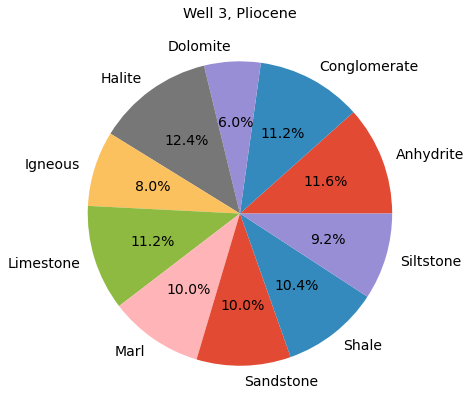

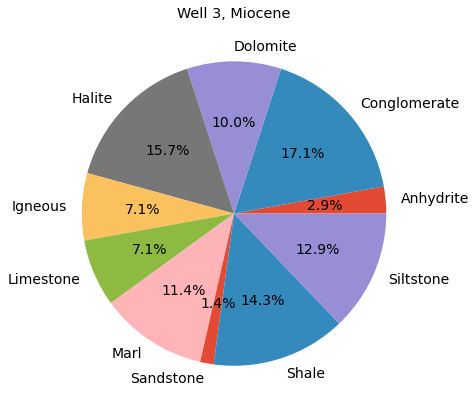

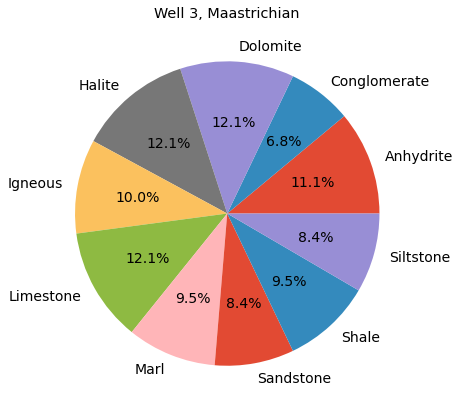

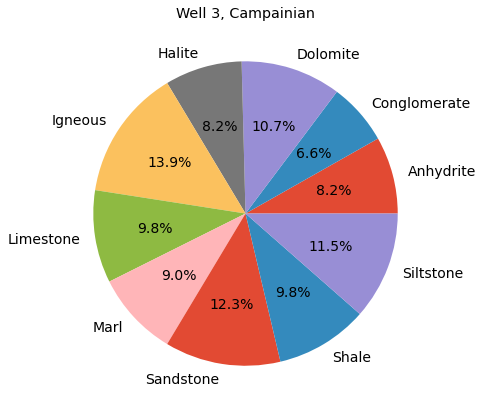

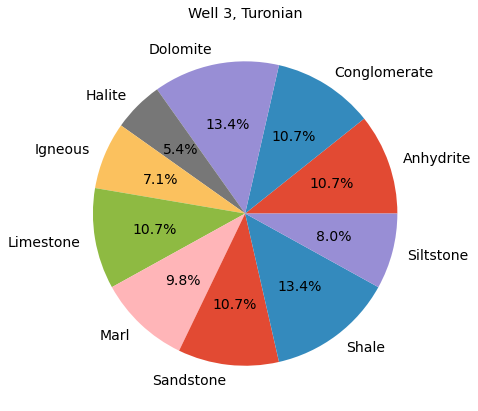

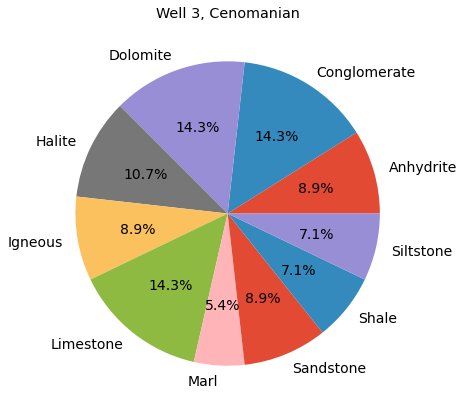

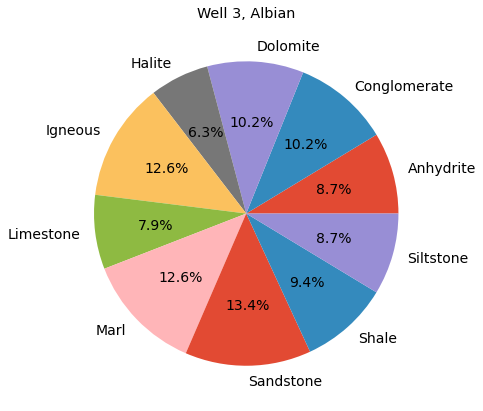

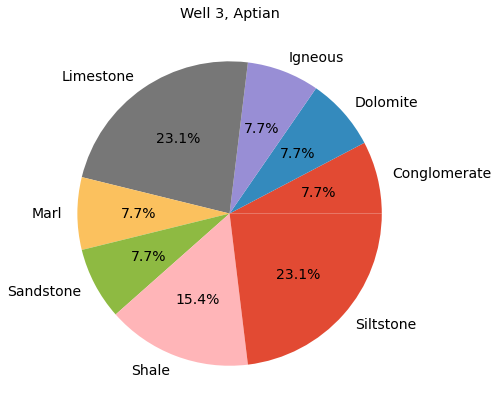

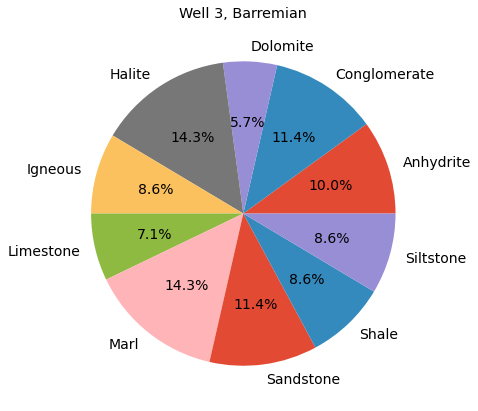

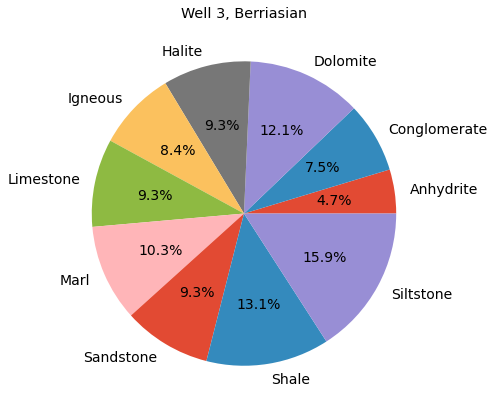

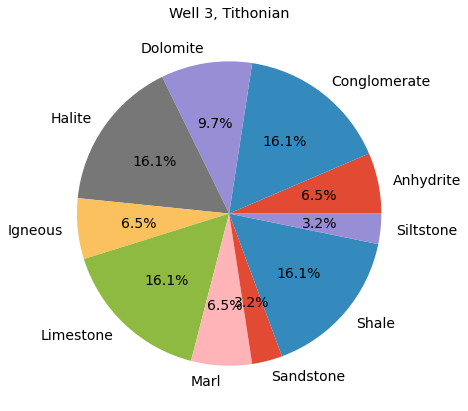

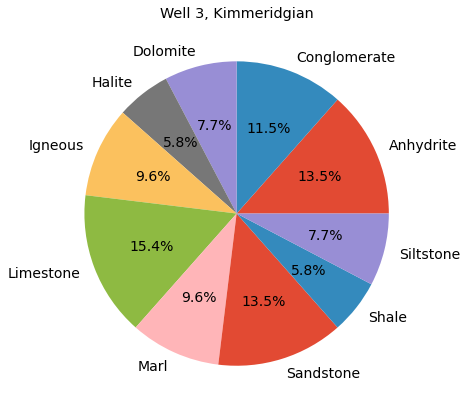

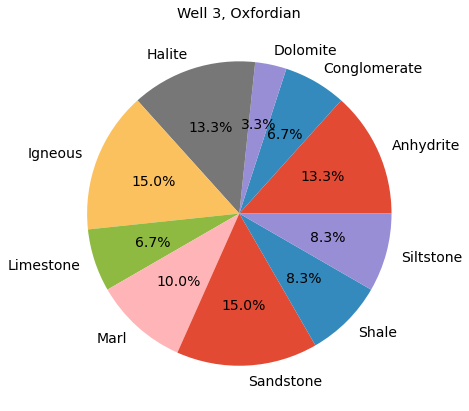

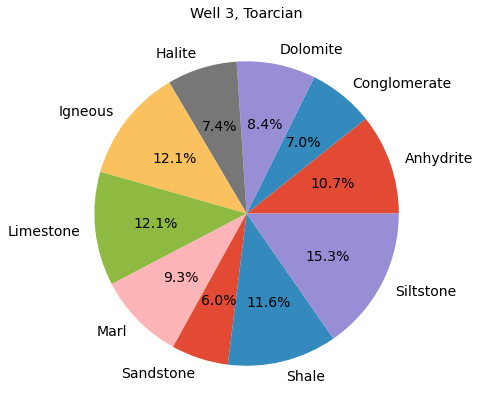

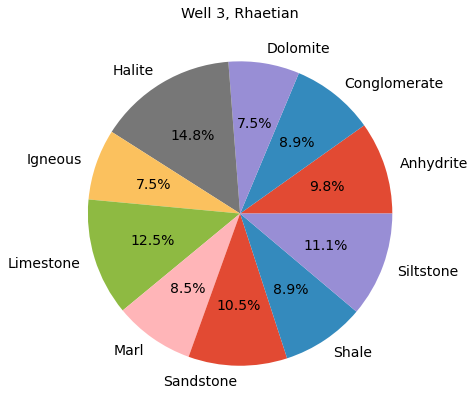

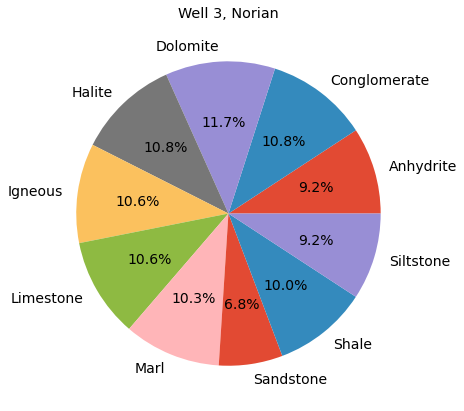

In [20]:
# Plot pie charts of lithology percentages for each formation

for fm in well_lith_well_resampled['formation'].unique():
    fm_filter = well_lith_well_resampled[well_lith_well_resampled['formation'] == fm]
    fm_filter_percent = fm_filter.groupby('lith_name')['thickness'].sum() / fm_filter['thickness'].sum() * 100
    plt.figure(figsize=[7,7])
    plt.title(f'{well_name}, {fm}')
    plt.pie(fm_filter_percent,
            normalize=True,
            autopct='%1.1f%%',
            labels=fm_filter.groupby('lith_name')['lith_name'].unique().index,
            textprops={'fontsize': 14})
    plt.show()

In [21]:
# END